# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    
    """Проверка на стационарность, делает тест Дикки-Фуллера и выводит результаты"""
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    """Визулизирует результаты, строит ряд, графики функции автокорреляции, остатков qqplot"""
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [5]:
# используем ряд sales_of_company_x
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")

### ARIMA

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда (пытается предсказать целевое значение временного ряда
- MA(q) - авторегрессии на ошибках первой (пытается найти "шоковые" значения по ошибкам)

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

Results of Dickey-Fuller Test:
Test Statistic                 -2.316045
p-value                         0.166845
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


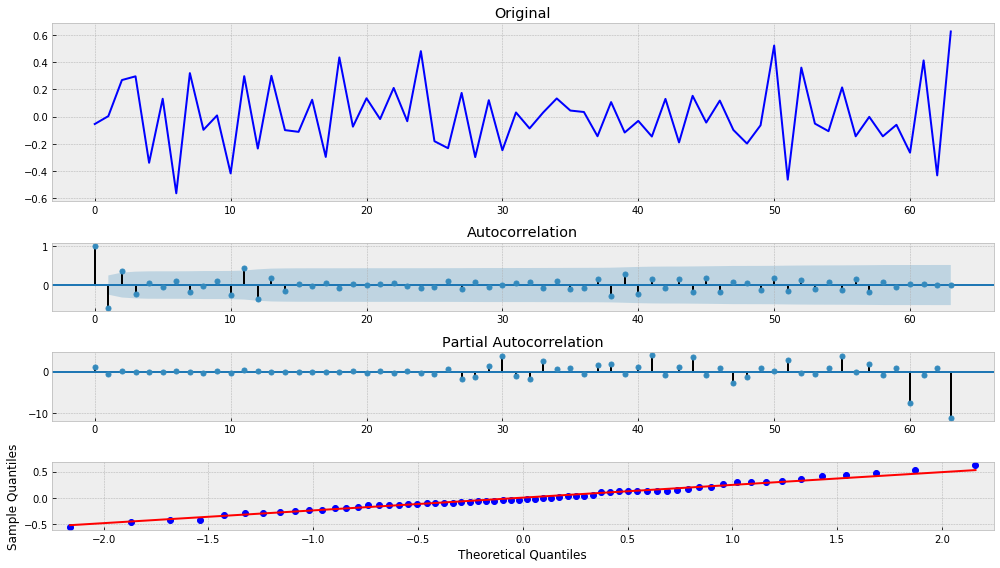

In [6]:
# попробуем привести ряд к стационарному
series = sales_of_company_x['Count']
series = boxcox(series, 0)
series = series[1:] - series[:-1]
series = series[12:] - series[:-12]

tsplot(series)

In [7]:
# подберем лчшие параметры для модели (по критерию Акаике)
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning:

aic: -24.79211 | order: (1, 0, 0)


Results of Dickey-Fuller Test:
Test Statistic                 -2.321234
p-value                         0.165211
#Lags Used                     11.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


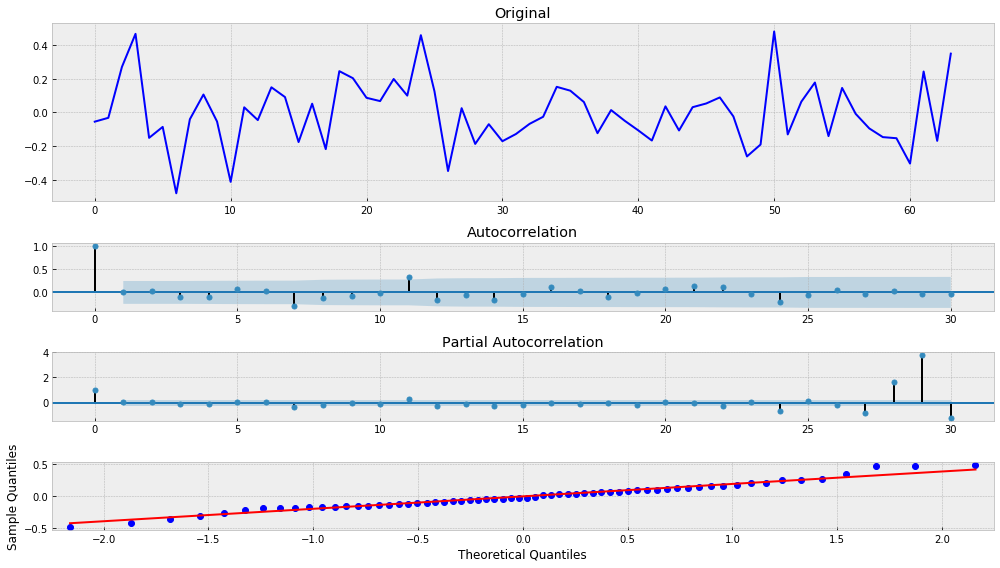

In [8]:
tsplot(best_mdl.resid, lags=30)

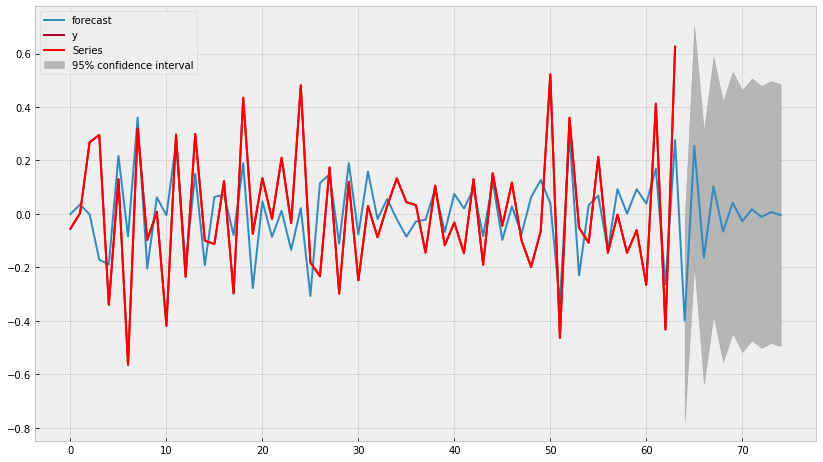

In [9]:
# попробуем предсказать на 10 точек вперед
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series)+10, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

### GARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [ ]:
!pip install git+https://github.com/bashtage/arch.git

In [ ]:
!pip install git+https://github.com/bashtage/arch.git --install-option="--no-binary"

In [10]:
from arch import arch_model

ValueError: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 192 from PyObject

In [11]:
# установить arch так и не получилось
# приблизим ряд при помощи регрессионной модели

## По простому

In [12]:
series = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")

In [13]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    """Функция разбивает ряд на трейн и тест, генерит фичи"""
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.4)

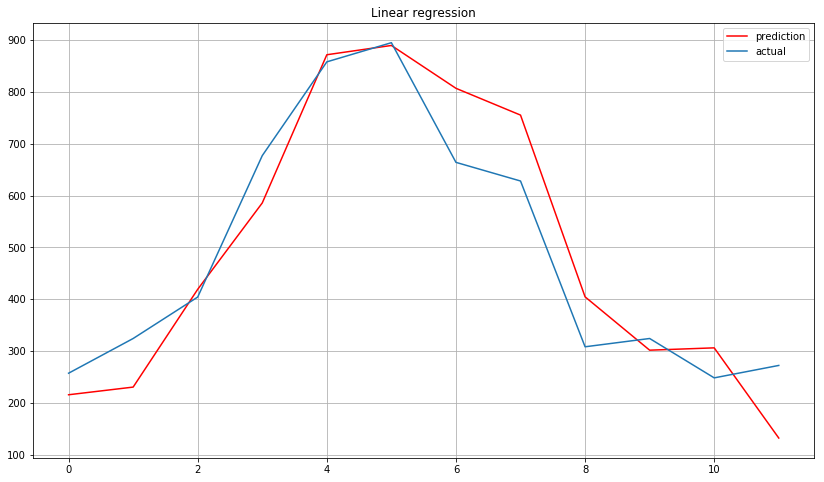

In [15]:
# посмотрим на приближение последних 40% значений ряда
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
mean_squared_error(prediction, y_test)

7393.044210916362

In [18]:
# Регрессионный подход работает неплохо